Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
0  :  3637_81536_41216     1
1  :  6790_14336_17024     1
2  :  6427_44800_8960     0
3  :  12166_22400_30464     0
4  :  3491_121856_35840     1
5  :  1302_10752_24192     1
6  :  13225_3584_34944     0
7  :  7473_9856_18816     1
8  :  15123_90496_18816     0
9  :  7309_5376_29568     0
10  :  1622_44800_16128     1
11  :  4366_41216_8064     1
12  :  6820_16128_5376     1
13  :  10629_8064_19712     0
14  :  7802_20608_29568     1
15  :  1588_9856_10752     1
16  :  6667_72576_24192     1
17  :  11974_76160_19712     0
18  :  10398_84224_18816     0
19  :  8024_69888_31360     0
20  :  5404_78848_32256     1
21  :  6292_14336_26880     1
22  :  3250_72576_17024     1
23  :  833_3584_47488     1
24  :  2536_92288_2688     1
25  :  7521_64512_21504     0
26  :  820_15232_21504     0
27  :  11590_15232_27776     0
28  :  912_49280_1792     0
29  :  5129_17024

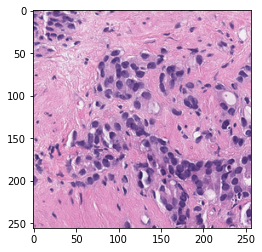

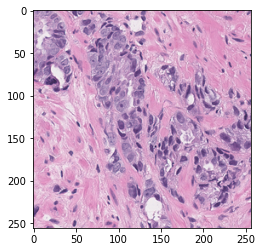

Data loaded
1420 540 540


In [ ]:
#based off https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_06_3_resnet.ipynb

# from __future__ import print_function
import tensorflow as tf
import tensorflow.keras
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
from tensorflow.keras.layers import Dense, Conv2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input
import matplotlib.pyplot as plt
import matplotlib.image as Image
from six.moves import cPickle 
import time
from datetime import datetime
import numpy as np
import os
import pandas
# from IPython.display import Image


from google.colab import drive
drive.mount('/content/drive')

pandas.options.mode.chained_assignment = None

LOAD_NEW = True #load extra 3k tiles or not

csv_location = '/content/drive/MyDrive/223B/dataset.csv'
data = pandas.read_csv(csv_location)

images = []
labels_ = data.label	


count =0
count_can = 0
count_ben = 0
for x in data.tile_name:
    print(count,' : ', x, '   ', labels_[count])
    images.append(np.array(Image.imread(os.path.join('/content/drive/MyDrive/223B/256_1/',x + '.png'))))
    count +=1

print('finished old')

if LOAD_NEW:
    csv_location_new = '/content/drive/MyDrive/223B/path_256_1_new/data/dataset.csv'
    data_new = pandas.read_csv(csv_location_new)
    print('blah')
    labels_new = data_new.label

    for x in data_new.tile_name:
        print(count,' : ', x, '   ', labels_new[count-1000])
        images.append(np.array(Image.imread(os.path.join('/content/drive/MyDrive/223B/path_256_1_new/',x + '.png'))))
        count +=1

    for x in range(len(labels_new)):
        if labels_new[x] == '0+0':
            labels_new[x] = 0
        else:
            labels_new[x] = 1
    labels = pandas.concat([labels_,labels_new]).array
	
    TRAIN_idx = 2400
    VALTEST_idx = 3200
else:
	labels = labels_.array
	TRAIN_idx = 600
	VALTEST_idx = 800
    
imgplot = plt.imshow(images[1000])
plt.show()
imgplot = plt.imshow(images[2000])
plt.show()




images = np.array(images,dtype=np.uint32) #memory issues

print("Data loaded")

#Load the data.
x_train = images[:TRAIN_idx]
x_val = images[TRAIN_idx:VALTEST_idx]
x_test = images[VALTEST_idx:]
y_train = labels[:TRAIN_idx]
y_val = labels[TRAIN_idx:VALTEST_idx]
y_test = labels[VALTEST_idx:] 

# x_train = images[:600]
# x_val = images[600:800]
# x_test = images[800:1000]
# y_train = labels[:600]
# y_val = labels[600:800]
# y_test = labels[800:1000] 

print( np.count_nonzero(y_train == 1),  np.count_nonzero(y_val == 1), np.count_nonzero(y_test == 1) )






def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"
    



In [ ]:
# parameters
BATCH_SIZE = 7 #high batch size = memory failure
EPOCHS = 35
USE_AUGMENTATION = True
num_classes = np.unique(y_train).shape[0] 
#num_classes = 2
LR = 5e-5
droprate = 0.05
#OPTIMIZER = SGD(lr=LR, nesterov = True)
OPTIMIZER = Adam(lr=LR)
SUBTRACT_PIXEL_MEAN = True
DEPTH = 110
num_units = 256
initializer = 'he_normal'  # 'he_uniform' #  # "glorot_uniform"


In [ ]:
# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_val = x_val.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if SUBTRACT_PIXEL_MEAN:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_val -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_val = tensorflow.keras.utils.to_categorical(y_val, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)

x_train shape: (2400, 256, 256, 3)
2400 train samples
800 test samples
y_train shape: (2400,)


In [ ]:
def ClsModel(num_units, droprate, n_classes=1, input_shape=(224,224,3), ):
    base_model = DenseNet121(weights=None, include_top=False, input_shape=input_shape)
    x = AveragePooling2D(pool_size=(3,3), name='avg_pool')(base_model.output)
    x = Flatten()(x)
    x = Dense(num_units, activation='relu', name='dense_post_pool')(x)
    x = Dropout(droprate)(x)
    output = Dense(n_classes, activation='softmax', name='predictions')(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model


class logCallback(tensorflow.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs=None):
		lr = K.get_value(self.model.optimizer.lr)
		val_acc = logs['val_accuracy']
		loss = logs['loss']
		print("Learning rate:", lr, " Accuracy:", val_acc, " Loss:", loss)				   


In [ ]:
import time
import math
import matplotlib.pyplot as plt
from tensorflow import keras

def evaluate_network(num_units, BATCH_SIZE, EPOCHS, dropout, LR):

  # full_evaluate_network has x_tr, y_tr, x_te, y_te, as input 

  OPTIMIZER = SGD(lr=LR)
  BATCH_SIZE = math.floor(BATCH_SIZE)
  EPOCHS = math.floor(EPOCHS)
  num_units = math.floor(num_units)

  x_tr = x_train
  y_tr = y_train
  x_te = x_val
  y_te = y_val


  model_new = ClsModel(num_units, dropout, num_classes, input_shape )

  model_new.compile(loss='categorical_crossentropy',
                optimizer=OPTIMIZER,
                metrics=['accuracy'])

  start_time = time.time()

  # Prepare callbacks for model saving and for learning rate adjustment.

  lr_reducer = ReduceLROnPlateau(factor=0.1, cooldown=0, patience=3)

  earl_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=9)
                  
          
  #callbacks = [lr_reducer,earl_stop]

  callbacks = [lr_reducer,earl_stop, logCallback()]

  print(BATCH_SIZE, EPOCHS, dropout, LR)


  # Run training, with or without data augmentation.
  if not USE_AUGMENTATION:
      print('Not using data augmentation.')
      history = model_new.fit(x_train, y_train,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                shuffle=True,
                callbacks=callbacks)
  else:
      print('Using real-time data augmentation.')
      # This will do preprocessing and realtime data augmentation:
      datagen = ImageDataGenerator(
          # set input mean to 0 over the dataset
          featurewise_center=False,
          # set each sample mean to 0
          samplewise_center=False,
          # divide inputs by std of dataset
          featurewise_std_normalization=False,
          # divide each input by its std
          samplewise_std_normalization=False,
          # apply ZCA whitening
          zca_whitening=False,
          # epsilon for ZCA whitening
          zca_epsilon=1e-06,
          # randomly rotate images in the range (deg 0 to 180)
          rotation_range=0,
          # randomly shift images horizontally
          width_shift_range=0.1,
          # randomly shift images vertically
          height_shift_range=0.1,
          # set range for random shear
          shear_range=0.,
          # set range for random zoom
          zoom_range=0.,
          # set range for random channel shifts
          channel_shift_range=0.,
          # set mode for filling points outside the input boundaries
          fill_mode='nearest',
          # value used for fill_mode = "constant"
          cval=0.,
          # randomly flip images
          horizontal_flip=True,
          # randomly flip images
          vertical_flip=False,
          # set rescaling factor (applied before any other transformation)
          rescale=None,
          # set function that will be applied on each input
          preprocessing_function=None,
          # image data format, either "channels_first" or "channels_last"
          data_format=None,
          # fraction of images reserved for validation 
          # (strictly between 0 and 1)
          validation_split=0.0)

      # Compute quantities required for featurewise normalization
      # (std, mean, and principal components if ZCA whitening is applied).
      datagen.fit(x_train)
      print('break')
      # Fit the model on the batches generated by datagen.flow().
      history = model_new.fit_generator(datagen.flow(x_train, y_train, 
                          batch_size=BATCH_SIZE),
                          validation_data=(x_val, y_val),
                          epochs=EPOCHS, verbose=0,
                          shuffle=True,
                          callbacks=callbacks)
        
  elapsed_time = time.time() - start_time
  print("Elapsed time: {}".format(hms_string(elapsed_time)))


  timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
  filename = "model_" + str(timestamp) 

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.savefig('loss.png')

  scores = model_new.evaluate(x_te, y_te, return_dict=False, verbose=0)
  print(scores)
  tensorflow.keras.backend.clear_session()
  return (scores[1])
  #return (- scores[0])

|   iter    |  target   | BATCH_... |  EPOCHS   |    LR     |  dropout  | num_units |
-------------------------------------------------------------------------------------
5 40 0.32558314315795994 0.0001001029373356104
Using real-time data augmentation.
break
Learning rate: 0.0001001029373356104  Accuracy: 0.41999998688697815  Loss: 1.000560998916626
Learning rate: 0.0001001029373356104  Accuracy: 0.5174999833106995  Loss: 0.8771660327911377
Learning rate: 0.0001001029373356104  Accuracy: 0.5724999904632568  Loss: 0.800221860408783
Learning rate: 0.0001001029373356104  Accuracy: 0.643750011920929  Loss: 0.7926668524742126
Learning rate: 0.0001001029373356104  Accuracy: 0.612500011920929  Loss: 0.7555456757545471
Learning rate: 0.0001001029373356104  Accuracy: 0.6287500262260437  Loss: 0.7529134750366211
Learning rate: 0.0001001029373356104  Accuracy: 0.6600000262260437  Loss: 0.7069010734558105
Learning rate: 0.0001001029373356104  Accuracy: 0.668749988079071  Loss: 0.7172250151634216


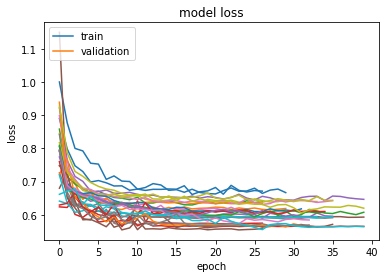

In [ ]:
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization
import time

# Supress NaN warnings
import warnings
warnings.filterwarnings("ignore",category =UserWarning)

import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)

# Bounded region of parameter space
pbounds = {'dropout': (0.25, 0.5), 
            'BATCH_SIZE': (5, 5),
            'EPOCHS': (40, 40),
           'LR': (1e-4, 1e-3),
           'num_units': (256,256)
           }



optimizer = BayesianOptimization(
    f=evaluate_network,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum 
    # is observed, verbose = 0 is silent
    random_state=1,
)

start_time = time.time()
optimizer.maximize(init_points=10, n_iter=5,)
time_took = time.time() - start_time

print(time_took)
#print(f"Total runtime: {hms_string(time_took)}")
print(optimizer.max)

|   iter    |  target   | BATCH_... |  EPOCHS   |    LR     |  dropout  | num_units |
-------------------------------------------------------------------------------------
5 40 0.1860496576843279 1.1142604425275418e-06
Using real-time data augmentation.
break
Learning rate: 1.1142604425275418e-06  Accuracy: 0.5625  Loss: 0.9665769338607788
Learning rate: 1.1142604425275418e-06  Accuracy: 0.625  Loss: 0.9164934158325195
Learning rate: 1.1142604425275418e-06  Accuracy: 0.574999988079071  Loss: 0.9041116237640381
Learning rate: 1.1142604425275419e-07  Accuracy: 0.5762500166893005  Loss: 0.9182827472686768
Learning rate: 1.1142604425275419e-07  Accuracy: 0.5837500095367432  Loss: 0.9162483811378479
Learning rate: 1.1142604425275419e-07  Accuracy: 0.574999988079071  Loss: 0.9140151739120483
Learning rate: 1.1142604425275419e-08  Accuracy: 0.5849999785423279  Loss: 0.9385057687759399
Learning rate: 1.1142604425275419e-08  Accuracy: 0.581250011920929  Loss: 0.9162530303001404
Learning rate: 1

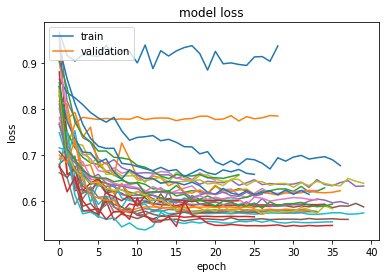

In [ ]:
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization
import time

# Supress NaN warnings
import warnings
warnings.filterwarnings("ignore",category =UserWarning)

import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)

# Bounded region of parameter space
pbounds = {'dropout': (0.05, 0.5), 
            'BATCH_SIZE': (5, 5),
            'EPOCHS': (40, 40),
           'LR': (1e-6, 1e-3),
           'num_units': (1024,1024)
           }



optimizer = BayesianOptimization(
    f=evaluate_network,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum 
    # is observed, verbose = 0 is silent
    random_state=1,
)

start_time = time.time()
optimizer.maximize(init_points=12, n_iter=5,)
time_took = time.time() - start_time

print(time_took)
#print(f"Total runtime: {hms_string(time_took)}")
print(optimizer.max)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 262, 262, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

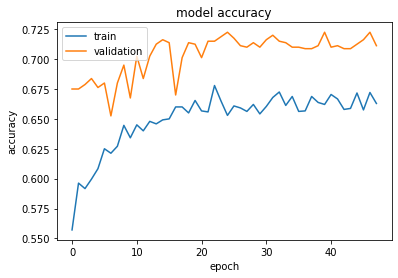

In [ ]:
droprate = 0.1
num_units = 1024
LR = 0.0008
EPOCHS = 60
OPTIMIZER = Adam(lr=LR)


model_new = ClsModel(num_units, droprate, num_classes, input_shape)

model_new.compile(loss='categorical_crossentropy',
              optimizer=OPTIMIZER,
              metrics=['accuracy'])
model_new.summary()

y_pred = model_new.predict(x_test)
print(y_pred)

start_time = time.time()

# Prepare callbacks for model saving and for learning rate adjustment.

lr_reducer = ReduceLROnPlateau(factor=0.1, cooldown=0, patience=3)

earl_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)
							   
# def decay_schedule(epoch, lr):
	# if (epoch < 58) and (lr > 1e-6):
		# lr *= 0.9
	# elif (epoch > 58):
		# lr *= 0.9
	# return lr
	
# lr_scheduler = LearningRateScheduler(decay_schedule)
							   

callbacks = [lr_reducer,earl_stop, logCallback()]

# Run training, with or without data augmentation.
if not USE_AUGMENTATION:
    print('Not using data augmentation.')
    history = model_new.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              validation_data=(x_val, y_val),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation 
        # (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)
    print('break')
    # Fit the model on the batches generated by datagen.flow().
    history = model_new.fit_generator(datagen.flow(x_train, y_train, 
                          batch_size=BATCH_SIZE),
                          validation_data=(x_val, y_val),
                          epochs=EPOCHS, verbose=1,
                          shuffle=True,
                          callbacks=callbacks)
    
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

#model.save("v1_32")
scores = model_new.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
filename = "model_" + str(timestamp) 

# # serialize model to JSON
# model_json = model.to_json()
# with open(filename + ".json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights(filename + ".h5")
# print("Saved model to disk")



#plots

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('accuracy.png')

plt.clf()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('loss.png')

plt.clf()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('accuracy.png')

